In [8]:
# Import required libraries
import pandas as pd
import numpy as np
from google.colab import files
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt

# Upload Excel files
file_names = ['amd3m.xlsx', 'amz3m.xlsx', 'tsla3m.xlsx']
data_dict = {}

for file in file_names:
    print(f"Please upload {file}")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    data_dict[file.split('.')[0]] = pd.read_excel(filename)

# Print available columns from first file as example
print("\nSample columns from amd3m:", list(data_dict['amd3m'].columns))

# Use specified column name
close_column = "Lst Trd/Lst Px"

# Extract closing prices
try:
    series_dict = {
        'AMD_3m': data_dict['amd3m'][close_column],
        'AMZ_3m': data_dict['amz3m'][close_column],
        'TSLA_3m': data_dict['tsla3m'][close_column]
    }
except KeyError:
    print(f"Error: Column '{close_column}' not found in one or more DataFrames")
    print("Please check the column names and try again")
    raise

# Function for unit root tests with interpretation
def unit_root_tests(series, name):
    print(f"\nUnit Root Tests for {name}:")

    # ADF Test
    adf_result = adfuller(series.dropna())
    print("ADF Test:")
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print(f'Critical Values: {adf_result[4]}')
    print("Interpretation:")
    if adf_result[1] >= 0.05:
        print(f"  - p-value >= 0.05: Fail to reject null - {name} may be non-stationary")
    else:
        print(f"  - p-value < 0.05: Reject null - {name} is stationary")

    # KPSS Test
    kpss_result = kpss(series.dropna())
    print("\nKPSS Test:")
    print(f'KPSS Statistic: {kpss_result[0]:.4f}')
    print(f'p-value: {kpss_result[1]:.4f}')
    print(f'Critical Values: {kpss_result[3]}')
    print("Interpretation:")
    if kpss_result[1] < 0.05:
        print(f"  - p-value < 0.05: Reject null hypothesis - {name} is non-stationary")
    else:
        print(f"  - p-value >= 0.05: Fail to reject null - {name} may be stationary")

# Perform unit root tests on original series
for name, series in series_dict.items():
    unit_root_tests(series, name)

# Function to find best ARIMA model
def find_best_arima(series, name, max_p=3, max_d=2, max_q=3):
    best_aic = float('inf')
    best_order = None

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                except:
                    continue

    print(f"\nBest ARIMA model for {name}:")
    print(f"Order: {best_order}")
    print(f"AIC: {best_aic:.2f}")
    print("Interpretation:")
    print(f"  - p={best_order[0]}: {best_order[0]} autoregressive term(s)")
    print(f"  - d={best_order[1]}: {best_order[1]} difference(s) needed for stationarity")
    print(f"  - q={best_order[2]}: {best_order[2]} moving average term(s)")

    best_model = ARIMA(series, order=best_order).fit()
    return best_model

# Fit ARIMA models to original series
models_dict = {}
for name, series in series_dict.items():
    models_dict[name] = find_best_arima(series.dropna(), name)

# Cointegration test with interpretation
def cointegration_test(df):
    result = coint_johansen(df, det_order=0, k_ar_diff=1)
    print("\nJohansen Cointegration Test:")
    print(f"Trace statistic: {result.lr1}")
    print(f"Critical values (90%, 95%, 99%): {result.cvt}")
    print("Interpretation:")
    for i in range(len(result.lr1)):
        if result.lr1[i] > result.cvt[i, 1]:  # 95% critical value
            print(f"  - r = {i}: Cointegration exists at 95% confidence level")
            print(f"    Trace statistic ({result.lr1[i]:.2f}) > 95% critical value ({result.cvt[i, 1]:.2f})")
        else:
            print(f"  - r = {i}: No cointegration at 95% confidence level")
            print(f"    Trace statistic ({result.lr1[i]:.2f}) <= 95% critical value ({result.cvt[i, 1]:.2f})")
    if all(result.lr1[i] <= result.cvt[i, 1] for i in range(len(result.lr1))):
        print("Conclusion: No evidence of cointegration between AMD_3m, AMZ_3m, and TSLA_3m")
    else:
        print("Conclusion: Evidence of cointegration exists")

# Prepare data for cointegration
coint_df = pd.DataFrame(series_dict).dropna()

# Run cointegration test
cointegration_test(coint_df)

# Function to plot forecasts and provide interpretation
def plot_forecast(model, series, name, steps=30):
    forecast_obj = model.get_forecast(steps=steps)
    forecast = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int()

    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Observed')
    plt.plot(forecast, label='Forecast', color='red')
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'{name} Price Forecast')
    plt.legend()
    plt.show()

    # Forecast interpretation
    last_value = series.iloc[-1]
    mean_forecast = forecast.mean

Please upload amd3m.xlsx


Saving AMD 3m.xlsx to AMD 3m (5).xlsx
Please upload amz3m.xlsx


Saving AMZ 3m.xlsx to AMZ 3m (3).xlsx
Please upload tsla3m.xlsx


Saving TSLA 3m.xlsx to TSLA 3m (3).xlsx

Sample columns from amd3m: ['Fecha', 'Lst Trd/Lst Px', 'Volume', 'SMAVG (15)']

Unit Root Tests for AMD_3m:
ADF Test:
ADF Statistic: -1.6136
p-value: 0.4761
Critical Values: {'1%': -3.4450642060791097, '5%': -2.868027634065253, '10%': -2.5702256691640515}
Interpretation:
  - p-value >= 0.05: Fail to reject null - AMD_3m may be non-stationary

KPSS Test:
KPSS Statistic: 0.6086
p-value: 0.0219
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Interpretation:
  - p-value < 0.05: Reject null hypothesis - AMD_3m is non-stationary

Unit Root Tests for AMZ_3m:
ADF Test:
ADF Statistic: -2.5593
p-value: 0.1017
Critical Values: {'1%': -3.4451307246616514, '5%': -2.86805689169311, '10%': -2.570241263729327}
Interpretation:
  - p-value >= 0.05: Fail to reject null - AMZ_3m may be non-stationary

KPSS Test:
KPSS Statistic: 1.1372
p-value: 0.0100
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Interpretation:
  

<ipython-input-8-3ff2aeec6f22>:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna())
<ipython-input-8-3ff2aeec6f22>:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna())
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/st


Best ARIMA model for AMD_3m:
Order: (2, 1, 0)
AIC: 129.85
Interpretation:
  - p=2: 2 autoregressive term(s)
  - d=1: 1 difference(s) needed for stationarity
  - q=0: 0 moving average term(s)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: Conver


Best ARIMA model for AMZ_3m:
Order: (2, 1, 2)
AIC: 590.08
Interpretation:
  - p=2: 2 autoregressive term(s)
  - d=1: 1 difference(s) needed for stationarity
  - q=2: 2 moving average term(s)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/st


Best ARIMA model for TSLA_3m:
Order: (2, 1, 2)
AIC: 1485.24
Interpretation:
  - p=2: 2 autoregressive term(s)
  - d=1: 1 difference(s) needed for stationarity
  - q=2: 2 moving average term(s)

Johansen Cointegration Test:
Trace statistic: [78.60688926 25.55071357  7.30294767]
Critical values (90%, 95%, 99%): [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Interpretation:
  - r = 0: Cointegration exists at 95% confidence level
    Trace statistic (78.61) > 95% critical value (29.80)
  - r = 1: Cointegration exists at 95% confidence level
    Trace statistic (25.55) > 95% critical value (15.49)
  - r = 2: Cointegration exists at 95% confidence level
    Trace statistic (7.30) > 95% critical value (3.84)
Conclusion: Evidence of cointegration exists


Please upload amd30m.xlsx


Saving AMD 30m.xlsx to AMD 30m (1).xlsx
Please upload amz30m.xlsx


Saving AMZ 30m.xlsx to AMZ 30m (1).xlsx
Please upload tsla30m.xlsx


Saving TSLA 30m.xlsx to TSLA 30m (1).xlsx

Sample columns from amd30m: ['Fecha', 'Lst Trd/Lst Px', 'Volume', 'SMAVG (15)']

Unit Root Tests for AMD_30m:
ADF Test:
ADF Statistic: 0.0921
p-value: 0.9655
Critical Values: {'1%': -3.4750180242954167, '5%': -2.8811408028842043, '10%': -2.577221358046935}
Interpretation:
  - p-value >= 0.05: Fail to reject null - AMD_30m may be non-stationary

KPSS Test:
KPSS Statistic: 1.5588
p-value: 0.0100
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Interpretation:
  - p-value < 0.05: Reject null hypothesis - AMD_30m is non-stationary

Unit Root Tests for AMZ_30m:
ADF Test:
ADF Statistic: -1.7524
p-value: 0.4044
Critical Values: {'1%': -3.4753253063120644, '5%': -2.881274703275226, '10%': -2.5772928360116873}
Interpretation:
  - p-value >= 0.05: Fail to reject null - AMZ_30m may be non-stationary

KPSS Test:
KPSS Statistic: 1.4775
p-value: 0.0100
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Interpret

<ipython-input-7-cad3a774eeb5>:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna())
<ipython-input-7-cad3a774eeb5>:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna())
<ipython-input-7-cad3a774eeb5>:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series.dropna())
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmode


Best ARIMA model for AMD_30m:
Order: (0, 1, 0)
AIC: 304.07
Interpretation:
  - p=0: 0 autoregressive term(s)
  - d=1: 1 difference(s) needed for stationarity
  - q=0: 0 moving average term(s)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/st


Best ARIMA model for AMZ_30m:
Order: (2, 2, 3)
AIC: 490.02
Interpretation:
  - p=2: 2 autoregressive term(s)
  - d=2: 2 difference(s) needed for stationarity
  - q=3: 3 moving average term(s)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:60


Best ARIMA model for TSLA_30m:
Order: (2, 2, 3)
AIC: 839.11
Interpretation:
  - p=2: 2 autoregressive term(s)
  - d=2: 2 difference(s) needed for stationarity
  - q=3: 3 moving average term(s)


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Johansen Cointegration Test:
Trace statistic: [14.46077693  3.56161781  0.0209041 ]
Critical values (90%, 95%, 99%): [[27.0669 29.7961 35.4628]
 [13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
Interpretation:
  - r = 0: No cointegration at 95% confidence level
    Trace statistic (14.46) <= 95% critical value (29.80)
  - r = 1: No cointegration at 95% confidence level
    Trace statistic (3.56) <= 95% critical value (15.49)
  - r = 2: No cointegration at 95% confidence level
    Trace statistic (0.02) <= 95% critical value (3.84)
Conclusion: No evidence of cointegration between AMD_30m, AMZ_30m, and TSLA_30m


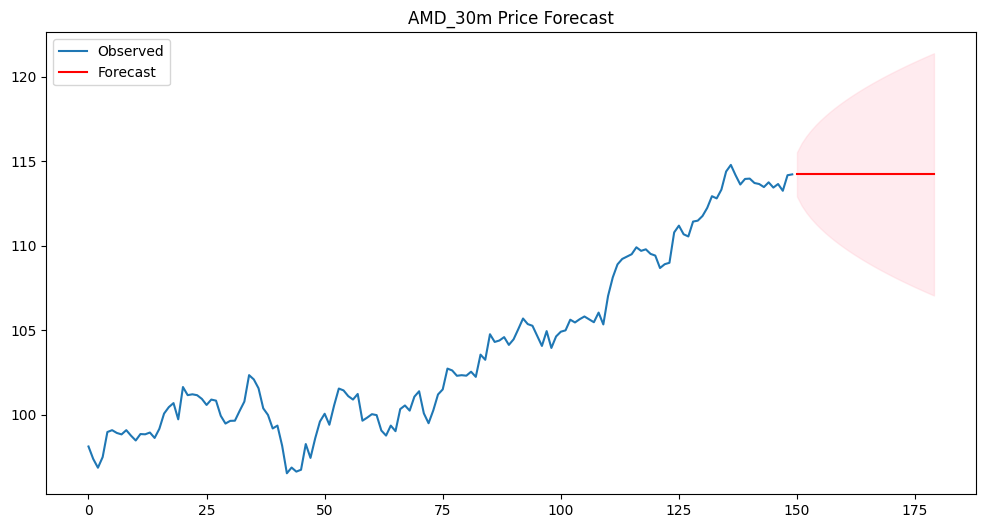


Forecast Interpretation for AMD_30m:
Last observed value: 114.22
Average forecast value: 114.22
Forecast change: -0.00
Trend: Downward forecast trend
95% CI range at period 30: [107.06, 121.38]


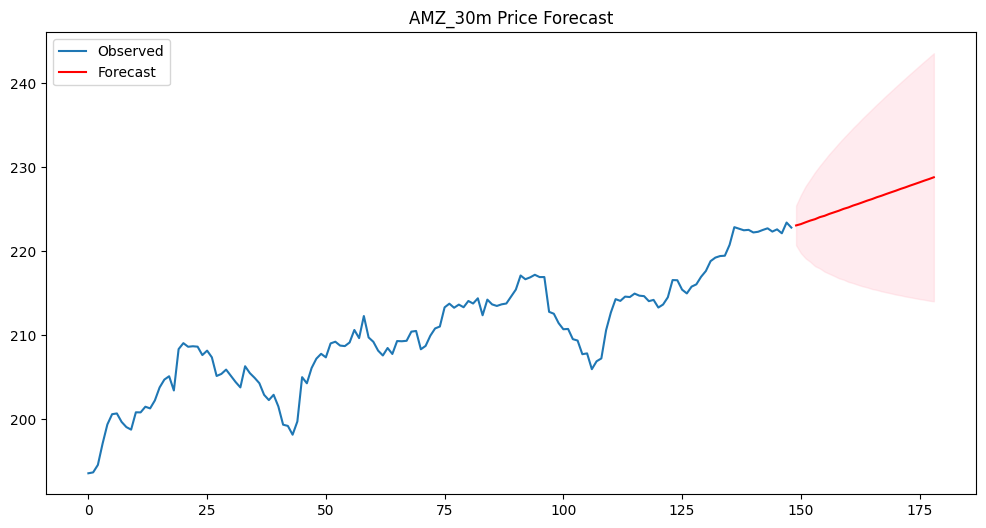


Forecast Interpretation for AMZ_30m:
Last observed value: 222.83
Average forecast value: 225.94
Forecast change: 3.11
Trend: Upward forecast trend
95% CI range at period 30: [214.06, 243.59]


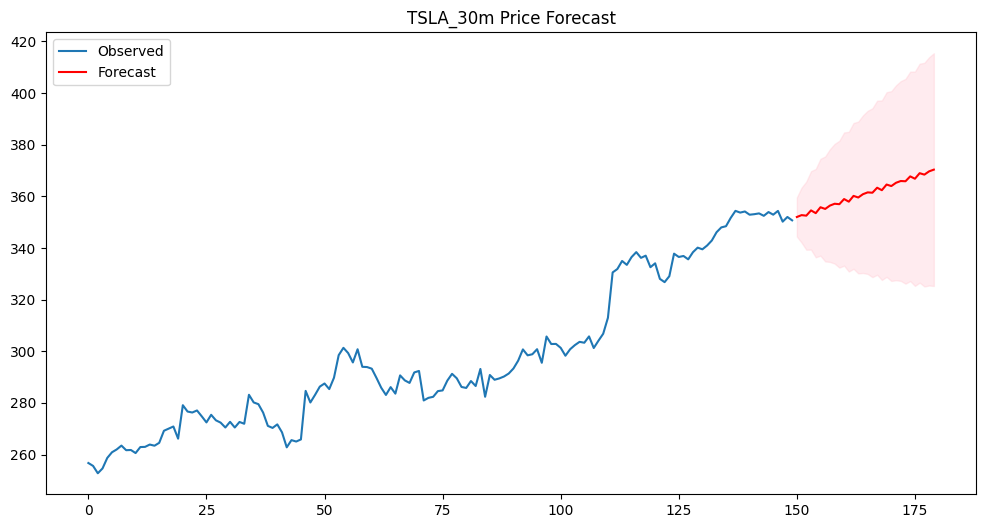


Forecast Interpretation for TSLA_30m:
Last observed value: 350.70
Average forecast value: 361.02
Forecast change: 10.31
Trend: Upward forecast trend
95% CI range at period 30: [325.28, 415.42]


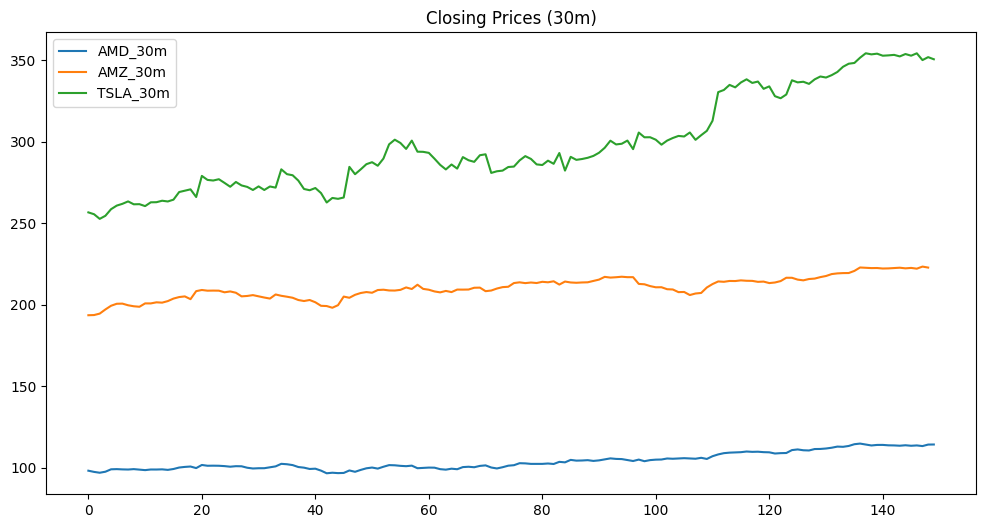

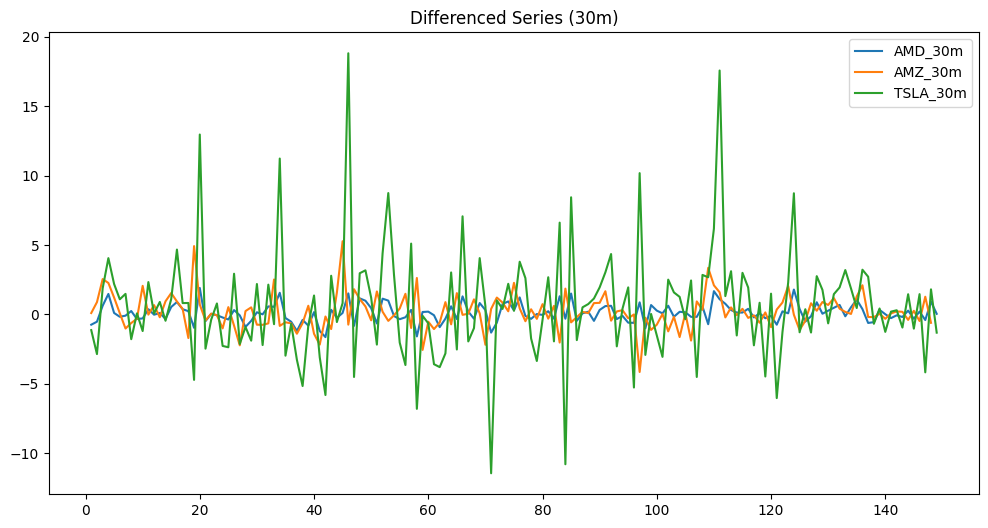


AMD_30m Forecast Values (next 5 periods):
150    114.22
151    114.22
152    114.22
153    114.22
154    114.22
Name: predicted_mean, dtype: float64

AMZ_30m Forecast Values (next 5 periods):
149    223.088391
150    223.241622
151    223.460069
152    223.666236
153    223.834652
Name: predicted_mean, dtype: float64

TSLA_30m Forecast Values (next 5 periods):
150    352.002048
151    352.729597
152    352.524834
153    354.561129
154    353.498785
Name: predicted_mean, dtype: float64


In [7]:
# Import required libraries
import pandas as pd
import numpy as np
from google.colab import files
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import matplotlib.pyplot as plt

# Upload Excel files
file_names = ['amd30m.xlsx', 'amz30m.xlsx', 'tsla30m.xlsx']
data_dict = {}

for file in file_names:
    print(f"Please upload {file}")
    uploaded = files.upload()
    filename = list(uploaded.keys())[0]
    data_dict[file.split('.')[0]] = pd.read_excel(filename)

# Print available columns from first file as example
print("\nSample columns from amd30m:", list(data_dict['amd30m'].columns))

# Use specified column name
close_column = "Lst Trd/Lst Px"

# Extract closing prices
try:
    series_dict = {
        'AMD_30m': data_dict['amd30m'][close_column],
        'AMZ_30m': data_dict['amz30m'][close_column],
        'TSLA_30m': data_dict['tsla30m'][close_column]
    }
except KeyError:
    print(f"Error: Column '{close_column}' not found in one or more DataFrames")
    print("Please check the column names and try again")
    raise

# Function for unit root tests with interpretation
def unit_root_tests(series, name):
    print(f"\nUnit Root Tests for {name}:")

    # ADF Test
    adf_result = adfuller(series.dropna())
    print("ADF Test:")
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print(f'Critical Values: {adf_result[4]}')
    print("Interpretation:")
    if adf_result[1] >= 0.05:
        print(f"  - p-value >= 0.05: Fail to reject null - {name} may be non-stationary")
    else:
        print(f"  - p-value < 0.05: Reject null - {name} is stationary")

    # KPSS Test
    kpss_result = kpss(series.dropna())
    print("\nKPSS Test:")
    print(f'KPSS Statistic: {kpss_result[0]:.4f}')
    print(f'p-value: {kpss_result[1]:.4f}')
    print(f'Critical Values: {kpss_result[3]}')
    print("Interpretation:")
    if kpss_result[1] < 0.05:
        print(f"  - p-value < 0.05: Reject null hypothesis - {name} is non-stationary")
    else:
        print(f"  - p-value >= 0.05: Fail to reject null - {name} may be stationary")

# Perform unit root tests on original series
for name, series in series_dict.items():
    unit_root_tests(series, name)

# Function to find best ARIMA model
def find_best_arima(series, name, max_p=3, max_d=2, max_q=3):
    best_aic = float('inf')
    best_order = None

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_order = (p, d, q)
                except:
                    continue

    print(f"\nBest ARIMA model for {name}:")
    print(f"Order: {best_order}")
    print(f"AIC: {best_aic:.2f}")
    print("Interpretation:")
    print(f"  - p={best_order[0]}: {best_order[0]} autoregressive term(s)")
    print(f"  - d={best_order[1]}: {best_order[1]} difference(s) needed for stationarity")
    print(f"  - q={best_order[2]}: {best_order[2]} moving average term(s)")

    best_model = ARIMA(series, order=best_order).fit()
    return best_model

# Fit ARIMA models to original series
models_dict = {}
for name, series in series_dict.items():
    models_dict[name] = find_best_arima(series.dropna(), name)

# Cointegration test with interpretation
def cointegration_test(df):
    result = coint_johansen(df, det_order=0, k_ar_diff=1)
    print("\nJohansen Cointegration Test:")
    print(f"Trace statistic: {result.lr1}")
    print(f"Critical values (90%, 95%, 99%): {result.cvt}")
    print("Interpretation:")
    for i in range(len(result.lr1)):
        if result.lr1[i] > result.cvt[i, 1]:  # 95% critical value
            print(f"  - r = {i}: Cointegration exists at 95% confidence level")
            print(f"    Trace statistic ({result.lr1[i]:.2f}) > 95% critical value ({result.cvt[i, 1]:.2f})")
        else:
            print(f"  - r = {i}: No cointegration at 95% confidence level")
            print(f"    Trace statistic ({result.lr1[i]:.2f}) <= 95% critical value ({result.cvt[i, 1]:.2f})")
    if all(result.lr1[i] <= result.cvt[i, 1] for i in range(len(result.lr1))):
        print("Conclusion: No evidence of cointegration between AMD_30m, AMZ_30m, and TSLA_30m")
    else:
        print("Conclusion: Evidence of cointegration exists")

# Prepare data for cointegration
coint_df = pd.DataFrame(series_dict).dropna()

# Run cointegration test
cointegration_test(coint_df)

# Function to plot forecasts and provide interpretation
def plot_forecast(model, series, name, steps=30):
    forecast_obj = model.get_forecast(steps=steps)
    forecast = forecast_obj.predicted_mean
    conf_int = forecast_obj.conf_int()

    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Observed')
    plt.plot(forecast, label='Forecast', color='red')
    plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
    plt.title(f'{name} Price Forecast')
    plt.legend()
    plt.show()

    # Forecast interpretation
    last_value = series.iloc[-1]
    mean_forecast = forecast.mean()
    print(f"\nForecast Interpretation for {name}:")
    print(f"Last observed value: {last_value:.2f}")
    print(f"Average forecast value: {mean_forecast:.2f}")
    print(f"Forecast change: {mean_forecast - last_value:.2f}")
    if mean_forecast > last_value:
        print("Trend: Upward forecast trend")
    elif mean_forecast < last_value:
        print("Trend: Downward forecast trend")
    else:
        print("Trend: Flat forecast trend")
    print(f"95% CI range at period {steps}: [{conf_int.iloc[-1, 0]:.2f}, {conf_int.iloc[-1, 1]:.2f}]")

# Generate detailed forecast plots and interpretations
for name, model in models_dict.items():
    plot_forecast(model, series_dict[name].dropna(), name)

# Plot original series
plt.figure(figsize=(12, 6))
for name, series in series_dict.items():
    plt.plot(series, label=name)
plt.title('Closing Prices (30m)')
plt.legend()
plt.show()

# Plot differenced series
diff_dict = {name: series.diff().dropna() for name, series in series_dict.items()}
plt.figure(figsize=(12, 6))
for name, series in diff_dict.items():
    plt.plot(series, label=name)
plt.title('Differenced Series (30m)')
plt.legend()
plt.show()

# Print forecast values for the next 5 periods
for name, model in models_dict.items():
    forecast = model.get_forecast(steps=5).predicted_mean
    print(f"\n{name} Forecast Values (next 5 periods):")
    print(forecast)